In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from tensorflow.python.framework import ops
import pickle
import os
from scipy.misc import imread

C:\Users\Rashid Ali\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def load_CIFAR_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y
    

def load_CIFAR10(ROOT):
    xs = []
    ys = []
    
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)    
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'C:/Users/Rashid Ali/Desktop/Deep Learning/HW2_0780819_RashidAli/2-CIFAR-10/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Package data into a dictionary
    return {'X_train': X_train, 'y_train': y_train,'X_val': X_val, 'y_val': y_val, 'X_test': X_test, 'y_test': y_test,}

def normalize(x):
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [4]:
data = get_CIFAR10_data()

train_x = data['X_train']
train_x = normalize(train_x)
train_y = data['y_train']
train_y = dense_to_one_hot(train_y,10)
validation_x = data['X_val']
validation_x = normalize(validation_x)
validation_y = data['y_val']
validation_y = dense_to_one_hot(validation_y,10)
test_x = data['X_test']
test_x = normalize(test_x)
test_y = data['y_test']
test_y = dense_to_one_hot(test_y,10)

print("Shape of Train_x:", train_x.shape)
print("Shape of Train_y:", train_y.shape)
print(".......................................")
print("Shape of Validation_x:", validation_x.shape)
print("Shape of Validation_y:", validation_y.shape)
print(".......................................")
print("Shape of Test_x:", test_x.shape)
print("Shape of Test_y:",test_y.shape )

Shape of Train_x: (49000, 32, 32, 3)
Shape of Train_y: (49000, 10)
.......................................
Shape of Validation_x: (1000, 32, 32, 3)
Shape of Validation_y: (1000, 10)
.......................................
Shape of Test_x: (1000, 32, 32, 3)
Shape of Test_y: (1000, 10)


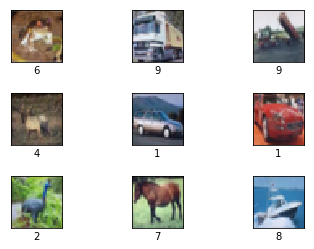

In [5]:
fig, axes = plt.subplots(3, 3)
fig.subplots_adjust(hspace=0.6, wspace=0.3)
for i, ax in enumerate(axes.flat):
    # Plot image.
    ax.imshow(train_x[i])
        
    # Name of the true class.
    #cls_true_name = num_to_class[y_train[i].argmax()]
    #xlabel = "class: {0}".format(cls_true_name)
        
    ## Show the classes as the label on the x-axis.
    ax.set_xlabel(np.argmax(train_y[i]))
        
    # Remove ticks from the plot.
    ax.set_xticks([])
    ax.set_yticks([])

In [6]:
 # variables for input and output 
def create_placeholder(H,W,C,y):
    
    train_x = tf.placeholder(tf.float32, shape=(None, H,W,C))
    train_y = tf.placeholder(tf.float32, shape=(None, y))
    
    return train_x, train_y

# weight initialization
def weight_variable(shape, name = None):
    
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name = name)

# bias initialization
def bias_variable(shape, name = None):
    
    initial = tf.constant(0.1, shape=shape) 
    return tf.Variable(initial, name = name)

# 2D convolution
def conv2d(x, W, name = None):
    
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name = name)

# max pooling
def max_pool_2x2(x, name = None):
    
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name = name)

In [7]:
def forward_propagation(X,Y):
    
    cache=dict()
    
    # 1.layer: convolution + max pooling
    W_conv1_tf = weight_variable([5,5,3,32], name = 'W_conv1_tf') # (5,5,1,32)
    b_conv1_tf = bias_variable([32], name = 'b_conv1_tf') # (32)
    h_conv1_tf = tf.nn.relu(conv2d(X,W_conv1_tf) + b_conv1_tf, name = 'h_conv1_tf') # (.,28,28,32)
    h_pool1_tf = max_pool_2x2(h_conv1_tf, name = 'h_pool1_tf') # (.,14,14,32)
    
    cache['h_conv1_tf']=h_conv1_tf
    cache['h_pool1_tf']= h_pool1_tf
    
    print(h_pool1_tf.shape)
    
    # 2.layer: convolution + max pooling
    W_conv2_tf = weight_variable([5,5,32,32],name = 'W_conv2_tf')
    b_conv2_tf = bias_variable([32], name = 'b_conv2_tf')
    h_conv2_tf = tf.nn.relu(conv2d(h_pool1_tf, W_conv2_tf) + b_conv2_tf, name ='h_conv2_tf') #(.,14,14,64)
    h_pool2_tf = max_pool_2x2(h_conv2_tf, name = 'h_pool2_tf') #(.,7,7,64)
    
    cache['h_conv2_tf']=h_conv2_tf
    cache['h_pool2_tf']= h_pool2_tf
    
    print(h_pool2_tf.shape)
    
    W_conv3_tf = weight_variable([3,3,32,64], name = 'W_conv3_tf')
    b_conv3_tf = bias_variable([64], name = 'b_conv3_tf')
    h_conv3_tf = tf.nn.relu(conv2d(h_pool2_tf, W_conv3_tf) + b_conv3_tf, name = 'h_conv3_tf') #(.,7,7,32)
    h_pool3_tf = max_pool_2x2(h_conv3_tf, name = 'h_pool3_tf') # (.,4,4,32)
    
    cache['h_conv3_tf']=h_conv3_tf
    cache['h_pool3_tf']= h_pool3_tf
    
    print(h_pool3_tf.shape)
    
    # 4.layer: fully connected
    W_fc1_tf = weight_variable([4*4*64,500], name = 'W_fc1_tf') # (4*4*32, 1024)
    b_fc1_tf = bias_variable([500], name = 'b_fc1_tf') # (1024)
    h_pool3_flat_tf = tf.reshape(h_pool3_tf, [-1,4*4*64], name = 'h_pool3_flat_tf') # (.,1024)
    h_fc1_tf = tf.nn.relu(tf.matmul(h_pool3_flat_tf,W_fc1_tf) + b_fc1_tf, name = 'h_fc1_tf') # (.,1024)
    
    cache['h_fc1_tf']=h_fc1_tf
    
    print(h_fc1_tf.shape)
    
    # 5.layer: fully connected
    W_fc2_tf = weight_variable([500, 10], name = 'W_fc2_tf')
    b_fc2_tf = bias_variable([10], name = 'b_fc2_tf')
    z_pred_tf = tf.add(tf.matmul(h_fc1_tf,W_fc2_tf), b_fc2_tf, name = 'z_pred_tf')# => (.,10)
    
    cache['z_pred_tf']= z_pred_tf
    
    
    # cost function
    cross_entropy_tf = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y , logits=z_pred_tf), name = 'cross_entropy_tf')
    
    #predicted probabilities in one-hot encoding
    y_pred_proba_tf = tf.nn.softmax(z_pred_tf, name='y_pred_proba_tf') 
    
    return cross_entropy_tf,  y_pred_proba_tf, cache

In [ ]:
tf.reset_default_graph()

with tf.Session() as sess:
    
    X,_,Y = create_placeholders(28, 28, 1, 10)
    loss = forward_propagation(X, Y)
    init  = tf.global_variables_initializer()
    sess.run(init)
    #a = sess.run(loss, {X: np.random.randn(50,28,28,1), Y: np.random.randn(50,10)})
    #a,b,c = sess.run([loss,fc3,fc4], {X: sample_x, Y: sample_y})
    #print(a.shape)
    #print("loss = " + str(a))
   

In [8]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    
    m = X.shape[0]                                           # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

   
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [9]:
def extract_weight(sess):
    # extract trained weights and biases
    weights= dict()
    W_conv1  = sess.run('W_conv1_tf:0')
    W_conv2  = sess.run('W_conv2_tf:0')
    W_conv3  = sess.run('W_conv3_tf:0')
    W_fc1    = sess.run('W_fc1_tf:0')
    W_output = sess.run('W_fc2_tf:0')
        
    b_conv1  = sess.run('b_conv1_tf:0')
    b_conv2  = sess.run('b_conv2_tf:0')
    b_conv3  = sess.run('b_conv3_tf:0')
    b_fc1    = sess.run('b_fc1_tf:0')
    b_output = sess.run('b_fc2_tf:0')
        
    weights['W_conv1']=W_conv1
    weights['W_conv2']=W_conv2
    weights['W_conv3']=W_conv3
    weights['W_fc1']=W_fc1
    weights['W_output']=W_output
        
    weights['b_conv1']=b_conv1
    weights['b_conv2']=b_conv2
    weights['b_conv3']=b_conv3
    weights['b_fc1']=b_fc1
    weights['b_output']=b_output
        
    return weights

In [20]:
def get_featuremap(sess,test_x,test_y,X,Y,cache,n):
           
            
            reshaped_x = np.reshape(test_x[n],(1,32,32,3))
            reshaped_y = np.reshape(test_y[n],(1,10))
            feed_dict = {X: reshaped_x,Y: reshaped_y}
            
            h_conv1_tf = cache['h_conv1_tf']
          
            h_pool1_tf = cache['h_pool1_tf']
            h_conv2_tf = cache['h_conv2_tf']
            h_pool2_tf = cache['h_pool2_tf']
            h_conv3_tf = cache['h_conv3_tf']
            h_pool3_tf = cache['h_pool3_tf']
            h_fc1_tf   = cache['h_fc1_tf']
            
            print('calculate feature map')
            feature_map1 = h_conv1_tf.eval(session=sess, feed_dict=feed_dict)
            print(feature_map1.shape)
            feature_map2 = h_conv2_tf.eval(session=sess, feed_dict=feed_dict)
            print(feature_map2.shape)
            feature_map3 = h_conv3_tf.eval(session=sess, feed_dict=feed_dict)
            print(feature_map3.shape)
            
         
            plt.imshow(test_x[n],cmap='gray')
            plt.title('Feature Map Image')
            plt.savefig('Feature Map Image')
            
            fm=np.reshape(feature_map1,(32,32,32))
            for i in range(9):
                plt.subplot(3,3,i+1)
                _=plt.imshow(fm[:,:,i],cmap='gray')
                
                plt.axis('off')
                plt.savefig('featuremap1',dpi=1000)
                
            
            
            fm=np.reshape(feature_map2,(16,16,32))
            for i in range(3):
                plt.subplot(3,3,i+1)
                _=plt.imshow(fm[:,:,i],cmap='gray')
                
                plt.axis('off')
                plt.savefig('featuremap2',dpi=1000)
                
            
            
            fm=np.reshape(feature_map3,(8,8,64))
            for i in range(9):
                plt.subplot(3,3,i+1)
                _=plt.imshow(fm[:,:,i],cmap='gray')
                plt.axis('off')
                plt.savefig('featuremap3',dpi=1000)
                

In [28]:
def model(train_x, train_y, valid_x,valid_y, test_x, test_y, learning_rate = 0.0001, num_epochs = 50, minibatch_size = 16, print_cost = True):
    
    
    ops.reset_default_graph()  
    
    (m, H, W, C) = train_x.shape             
    n_y = train_y.shape[1]                            
    train_losses = [] 
    
    train_acc = []
    valid_acc = []
    test_acc  = []
    
    weights = dict()
    cache_layers = dict()
    
    seed = 3  
    X,Y = create_placeholder(H, W, C, n_y)
    loss, fc4, cache_layers  = forward_propagation(X, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(train_x, train_y, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # Run the session to execute the optimizer and the cost on minibatch
                _ , temp_cost = sess.run([optimizer,loss], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost of training data after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                train_losses.append(minibatch_cost)


            # Calculate the correct predictions
            predict_op = tf.argmax(fc4, 1)
            correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
            # Calculate accuracy on the test set
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
            
            train_accuracy = 0
            valid_accuracy = 0
            test_accuracy =  0
            
            for minibatch in minibatches:
            
                (minibatch_X, minibatch_Y) = minibatch
                temp_accuracy = accuracy.eval({X: minibatch_X, Y: minibatch_Y})
                train_accuracy += temp_accuracy / num_minibatches
            
            if print_cost == True and epoch % 1 == 0:
                train_acc.append(train_accuracy)
       
            
            
            valid_accuracy = accuracy.eval({X: valid_x, Y: valid_y})
            if print_cost == True and epoch % 1 == 0:
                valid_acc.append(valid_accuracy)
            
            test_accuracy = accuracy.eval({X: test_x, Y: test_y})
            if print_cost == True and epoch % 1 == 0:
                test_acc.append(test_accuracy)
        
        #print accuracies
       
        print("Train Accuracy:", train_accuracy)
        print("Validation Accuracy:", valid_accuracy)
        print("Test Accuracy:", test_accuracy)
        
        #extract feature_maps
        get_featuremap(sess,test_x, test_y, X,Y, cache_layers,10)
        
        # extract weights
        
        weights = extract_weight(sess)
        
        #Visualize missclassified and correctly classified images
        
        pred_y= fc4.eval(feed_dict = {X:test_x})
        y_valid_pred_label = np.argmax(pred_y,1)
        y_valid_label = np.argmax(test_y,1)
        y_val_false_index = []
        y_val_true_index = []
        
       
        
        for i in range(y_valid_label.shape[0]):
            if y_valid_pred_label[i] != y_valid_label[i]:
                y_val_false_index.append(i)

        print('# False predictions: ', len(y_val_false_index),'out of', len(test_y))
        
        plt.figure(figsize=(6,10))
        for j in range(0,1):
            for i in range(0,4):
                if j*10+i<len(y_val_false_index):
                    plt.subplot(1,4,j*10+i+1)
                    plt.title('label:'+str(y_valid_label[y_val_false_index[j*10+i]])+'  pred:'+
                               str(y_valid_pred_label[y_val_false_index[j*10+i]]))
                    plt.imshow(test_x[y_val_false_index[j*10+i]],cmap='gray') 
                    plt.savefig('miss_classfied')
        
        for k in range(y_valid_label.shape[0]):
            if y_valid_pred_label[k] == y_valid_label[k]:
                y_val_true_index.append(k)
                
        print('# True predictions: ', len(y_val_true_index),'out of', len(test_y))
        
        plt.figure(figsize=(6,10))
        for j in range(0,1):
            for i in range(0,4):
                if j*10+i<len(y_val_false_index):
                    plt.subplot(1,4,j*10+i+1)
                    plt.title('label:'+str(y_valid_label[y_val_true_index[j*10+i]])+'  pred:'+str(y_valid_pred_label[y_val_true_index[j*10+i]]))
                    plt.imshow(test_x[y_val_true_index[j*10+i]],cmap='gray') 
                    plt.savefig('Correct_classified')
        
        
        return train_acc, valid_acc, test_acc, train_losses,weights,fc4
    

(?, 16, 16, 32)
(?, 8, 8, 32)
(?, 4, 4, 64)
(?, 500)
Cost of training data after epoch 0: 1.629587
Cost of training data after epoch 5: 0.949054
Cost of training data after epoch 10: 0.707985
Cost of training data after epoch 15: 0.520754
Cost of training data after epoch 20: 0.354282
Cost of training data after epoch 25: 0.216922
Cost of training data after epoch 30: 0.120433
Cost of training data after epoch 35: 0.069588
Cost of training data after epoch 40: 0.044739
Cost of training data after epoch 45: 0.035319
Train Accuracy: 0.9967137491835031
Validation Accuracy: 0.69
Test Accuracy: 0.699
calculate feature map
(1, 32, 32, 32)
(1, 16, 16, 32)
(1, 8, 8, 64)


C:\Users\Rashid Ali\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


# False predictions:  301 out of 1000
# True predictions:  699 out of 1000


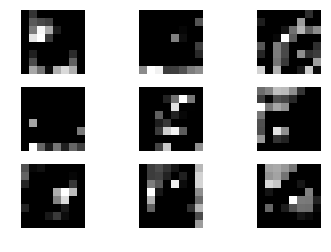

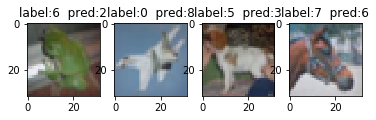

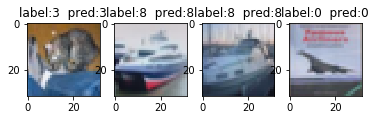

In [29]:
train_acc,valid_acc,test_acc,train_losses,weights,fc4 = model(train_x, train_y, validation_x, validation_y, test_x, test_y)


In [ ]:

# plot the loss
plt.plot(np.squeeze(train_losses), 'g',label='Cross entropy')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.title("Learning Curve")
#plt.ylim(ymax = 28, ymin = 0.0001)
plt.legend(loc='upper right')
plt.savefig('Learning Curve')
plt.show() 

In [ ]:
len(train_acc)

In [ ]:
len(valid_acc)

In [ ]:
plt.plot(np.arange(0,len(train_acc)), train_acc,'-b', label='Training Accuracy')
plt.plot(np.arange(0,len(valid_acc)), valid_acc,'-g', label='Validation Accuracy')
plt.plot(np.arange(0,len(test_acc)), test_acc,'-r', label='Test Accuracy')
plt.title("Training Accuracy")
plt.legend(loc='lower right', frameon=False)
plt.ylim(ymax = 1.00, ymin = 0.45)
plt.ylabel('Accuracy Rate')
plt.xlabel('Iteration')
plt.savefig('Training Accuracy')

In [ ]:
#plot distribution of weights and biases
W_conv1 =weights['W_conv1']
W_conv2 =weights['W_conv2']
W_conv3 =weights['W_conv3']
W_fc1   =weights['W_fc1']
W_output=weights['W_output']
        
b_conv1 =weights['b_conv1']
b_conv2 =weights['b_conv2']
b_conv3 =weights['b_conv3']
b_fc1   =weights['b_fc1']
b_output=weights['b_output']


In [ ]:
W_conv2.shape

In [ ]:
#plt.figure(figsize=(10, 5));
#plt.subplot(1,2,1);
#num_bins=10
W_conv1=W_conv1.reshape((25, 96))
plt.hist(W_conv1)
plt.xlabel('Value')
plt.ylabel('Number')
plt.title('Histogram of Conv1')
plt.savefig('Histogram of Conv1')

In [ ]:
W_conv2=W_conv2.reshape((25, 1024))
plt.hist(W_conv2)
plt.xlabel('Value')
plt.ylabel('Number')
plt.title('Histogram of Conv2')
plt.savefig('Histogram of Conv2')

In [ ]:
#plt.subplot(1,2,2)
plt.hist(W_fc1)
plt.xlabel('Value')
plt.ylabel('Number')
plt.title('Histogram of dense1')
plt.savefig('Histogram of dense1')

In [ ]:
#plt.subplot(1,2,2)
plt.hist(W_output)
plt.xlabel('Value')
plt.ylabel('Number')
plt.title('Histogram of output')
plt.savefig('Histogram of output')

In [ ]:
#wb=tf.trainable_variables()


In [ ]:
(m, H, W, C) = train_x.shape             
n_y = train_y.shape[1] 
    
X,Y = create_placeholder(H, W, C, n_y)
loss, fc4  = forward_propagation(X, Y)

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    w=sess.run('h_conv1_tf:0')
    #print(w)
   

In [ ]:
 def getActivations(layer,stimuli):
        units = sess.run(layer,feed_dict={X:np.reshape(stimuli,[1,784],order='F')})
        plotNNFilter(units)
    

In [ ]:
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

In [ ]:
imageToUse = mnist.test.images[0]
plt.imshow(np.reshape(imageToUse,[28,28]), interpolation="nearest", cmap="gray")